### 0. Standard setup for logging and plotting inside a notebook

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
%matplotlib inline

### 1. Choose a representative species for a case study

In [3]:
# download from Google Drive: https://drive.google.com/open?id=0B9cazFzBtPuCOFNiUHYwcVFVODQ
# Representative example with multiple polygons in the shapefile, and a lot of point-records (also outside rangemaps)
from iSDM.species import IUCNSpecies
salmo_trutta = IUCNSpecies(name_species='Salmo trutta')
salmo_trutta.load_shapefile("../data/fish/selection/salmo_trutta")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/salmo_trutta
The shapefile contains data on 3 species areas.


### 2. Rasterize the species, to get a matrix of pixels

In [4]:
rasterized = salmo_trutta.rasterize(raster_file="./salmo_trutta_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./salmo_trutta_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


#### 2.1 Plot to get an idea

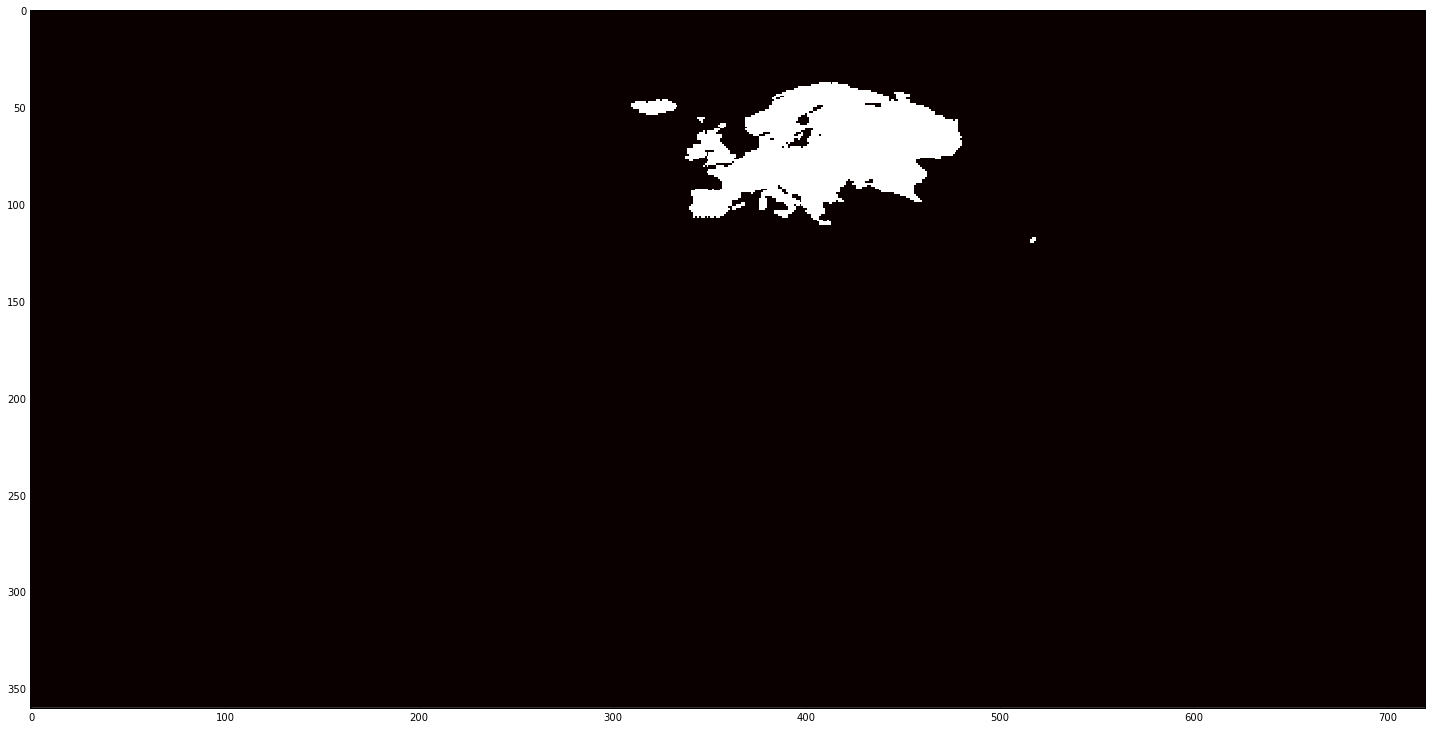

In [5]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized, cmap="hot", interpolation="none")

### 3. Load the biogeographical regons raster layer

In [29]:
from iSDM.environment import RasterEnvironmentalLayer
biomes_adf = RasterEnvironmentalLayer(file_path="../data/rebioms/w001001.adf", name_layer="Biomes")
biomes_adf.load_data()

Loaded raster data from ../data/rebioms/w001001.adf 
Driver name: AIG 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'AIG',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 255.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/rebioms/w001001.adf' mode='r'>

#### 3.1 Plot to get an idea

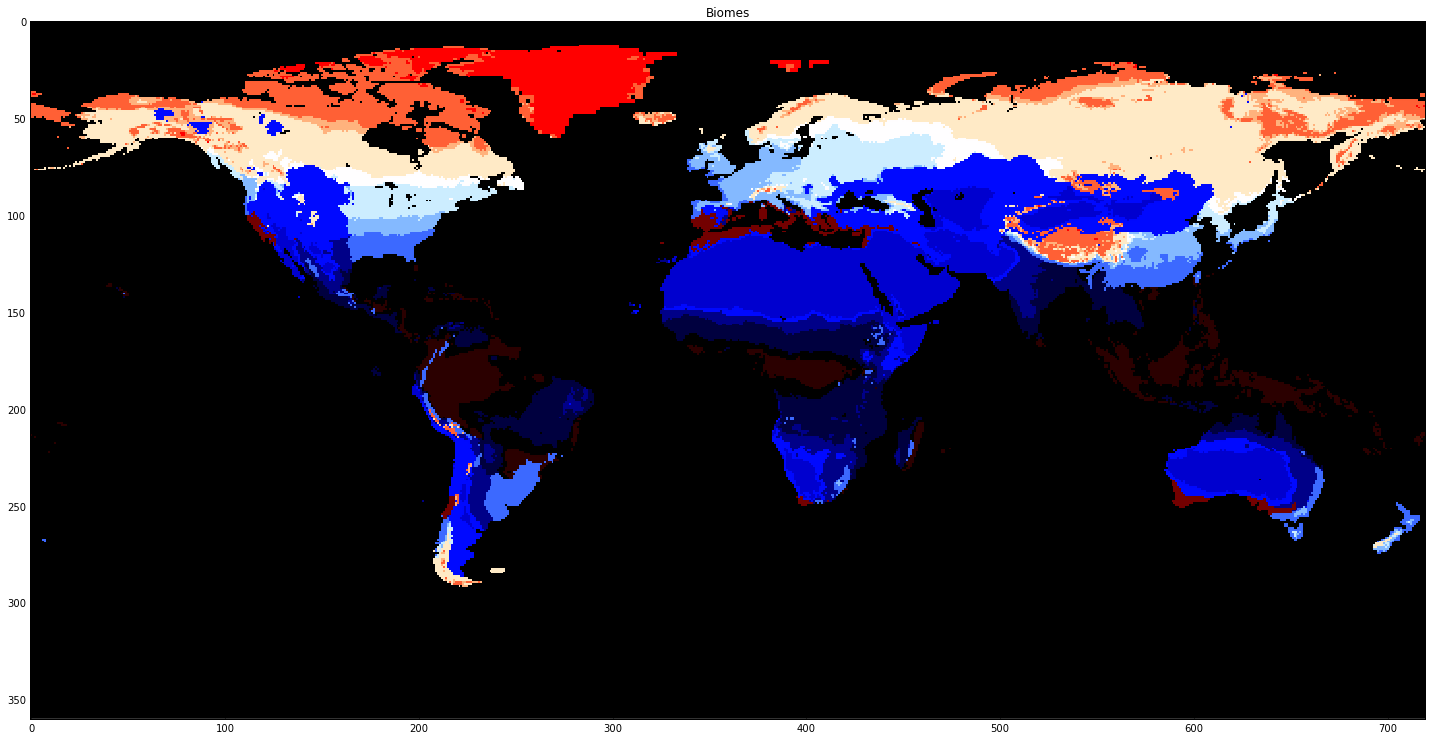

In [30]:
biomes_adf.plot()

### 4. Sample pseudo-absence pixels, taking into account all the distinct biomes that fall in the species region.

In [57]:
selected_layers, pseudo_absences = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[ 8  9 10 11 12 13 14 15 17 21]
There are 36793 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 983 unique pixels.


#### 4.1 Plot the biomes taken into account for sampling pseudo-absences, to get an idea

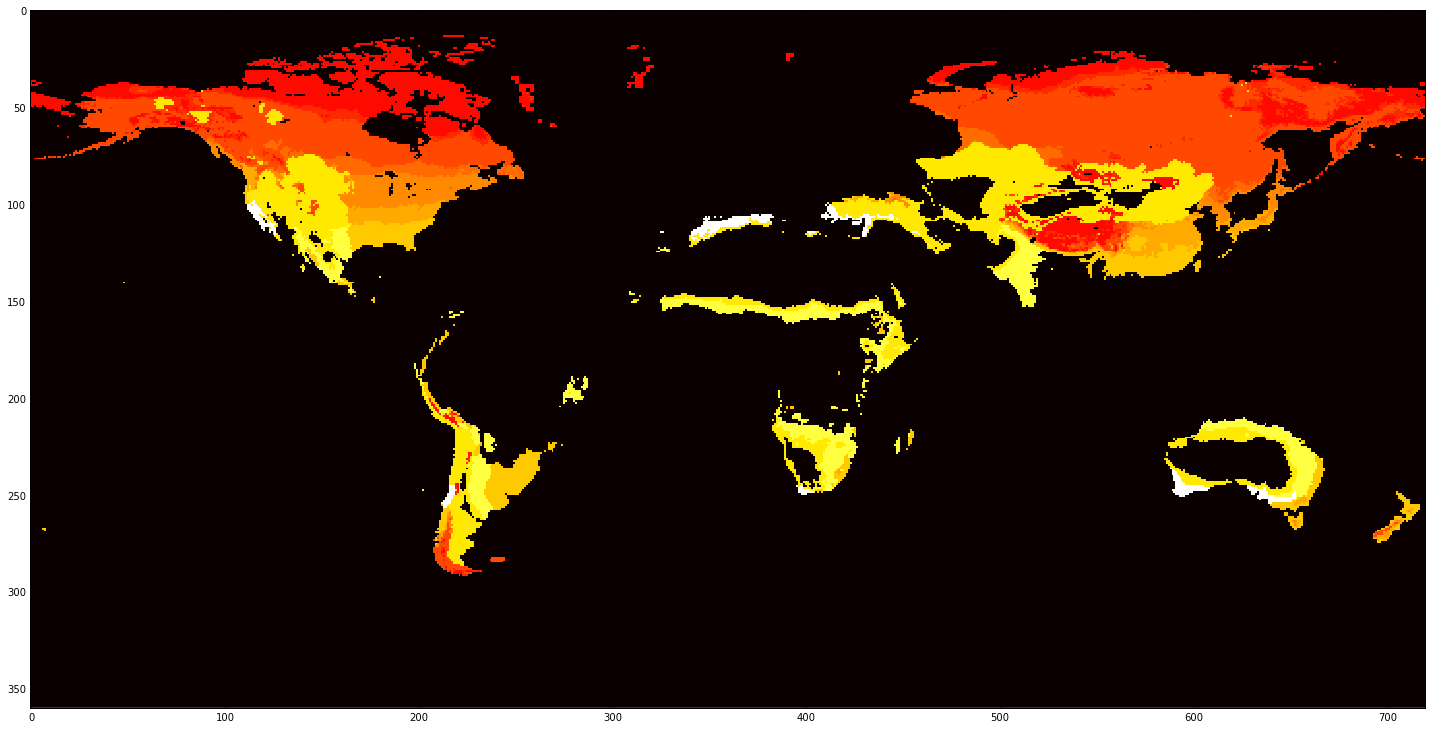

In [58]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers, cmap="hot", interpolation="none")

#### 4.2 Plot the sampled pseudo-absences, to get an idea

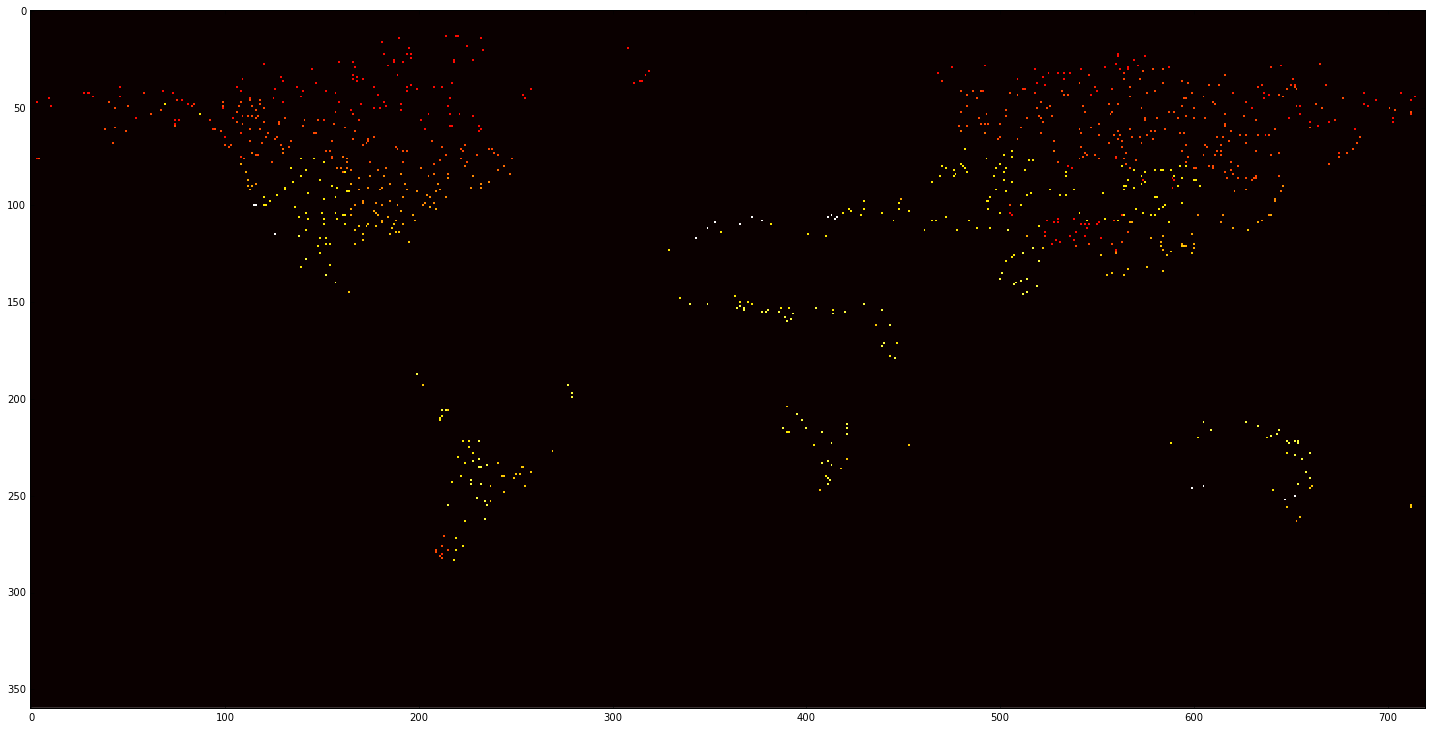

In [59]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences, cmap="hot", interpolation="none")

### 5. Construct a convenient dataframe for testing with different SDM models
For the Example 2 datasheet, all cells of a global raster map are needed, one pixel per row.

#### 5.1 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a "base" (zeroes) raster map. 

In [69]:
all_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=np.zeros_like(rasterized), filter_no_data_value=False)

Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Not filtering any no_data pixels.


In [70]:
all_coordinates

(array([ 89.75,  89.75,  89.75, ..., -89.75, -89.75, -89.75]),
 array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]))

In [71]:
base_dataframe = pd.DataFrame([all_coordinates[0], all_coordinates[1]]).T
base_dataframe.columns=['decimallatitude', 'decimallongitude']

In [72]:
base_dataframe.head()

,decimallatitude,decimallongitude
0,89.75,-179.75
1,89.75,-179.25
2,89.75,-178.75
3,89.75,-178.25
4,89.75,-177.75


#### 5.2 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a presences pixel map

In [73]:
presence_coordinates = salmo_trutta.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./salmo_trutta_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./salmo_trutta_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [74]:
presence_coordinates

(array([ 71.25,  71.25,  71.25, ...,  30.75,  30.25,  30.25]),
 array([ 23.75,  24.25,  24.75, ...,  79.25,  78.25,  78.75]))

In [75]:
presences_dataframe = pd.DataFrame([presence_coordinates[0], presence_coordinates[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[salmo_trutta.name_species] = 1 # fill presences with 1's
presences_dataframe.head()

,decimallatitude,decimallongitude,Salmo trutta
0,71.25,23.75,1
1,71.25,24.25,1
2,71.25,24.75,1
3,71.25,25.25,1
4,71.25,25.75,1


#### 5.3 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a pseudo_absences pixel map

In [77]:
pseudo_absence_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences)

Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [78]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates[0], pseudo_absence_coordinates[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[salmo_trutta.name_species] = 0

In [80]:
pseudo_absences_dataframe.head()

,decimallatitude,decimallongitude,Salmo trutta
0,83.25,-72.75,0
1,83.25,-70.25,0
2,83.25,-69.75,0
3,82.75,-84.75,0
4,82.75,-63.75,0


In [90]:
merged1 = pd.merge(base_dataframe, presences_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")

In [84]:
merged1.head()

,decimallatitude,decimallongitude,Salmo trutta
0,89.75,-179.75,NaN
1,89.75,-179.25,NaN
2,89.75,-178.75,NaN
3,89.75,-178.25,NaN
4,89.75,-177.75,NaN


In [91]:
merged2 = pd.merge(merged1, pseudo_absences_dataframe, on=["decimallatitude", "decimallongitude", salmo_trutta.name_species], how="outer")

In [106]:
merged2[merged2['Salmo trutta']==0].shape[0] # should be equal to number of pseudo absences below

983

In [107]:
pseudo_absence_coordinates[0].shape[0]

983

In [108]:
merged2[merged2['Salmo trutta']==1].shape[0]  # should be equal to number of presences below

6089

In [109]:
presence_coordinates[0].shape[0]

6089

In [123]:
merged2[merged2['Salmo trutta'].isnull()].shape[0] # all that's left

253111

In [125]:
253111 + 6089 # == all pixels in 360 x 720

259200